# Machine Learning with Spark

#### Student no : 21426682
#### Student name : Said Furkan Ayvaz


## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

This experiment aims to try to find out how we can diagnose breast cancer, using the machine learning methods in Spark Environment from the features created by digitizing the images of breast cancer. These features define the properties of the cell nuclei in the image. Your primary purpose here is to cluster and classify the data according to the diagnosis (M = malignant, B = benign).

We need to accurately predict the disease using clustering and classification methods. If the data set contains missing values, we should explain how to deal with them. After analyzing the dataset, it is determined which properties are used for clustering and classification in order to make accurate predictions.

By comparing the results we obtained, the most accurate method is determined for this problem. We try to identify what affects the results.

##Running Pyspark in Colab

To run spark in Colab, we need to first install all the dependencies in Colab environment i.e. Apache Spark 2.4.5 with hadoop 2.7, Java 8 and Findspark to locate the spark in the system.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import *
import seaborn as sns

%matplotlib inline

## Data Understanding<a class="anchor" id="data_understanding"></a>

In [183]:
# import the data and quickly check the format
# url = 'https://raw.githubusercontent.com/saidFurkan/Mahcine-Learning-with-Python/master/data.csv'
data = spark.createDataFrame(pd.read_csv('data.csv'))
print(data)
data.show(5)

DataFrame[id: bigint, diagnosis: string, radius_mean: double, texture_mean: double, perimeter_mean: double, area_mean: double, smoothness_mean: double, compactness_mean: double, concavity_mean: double, concave points_mean: double, symmetry_mean: double, fractal_dimension_mean: double, radius_se: double, texture_se: double, perimeter_se: double, area_se: double, smoothness_se: double, compactness_se: double, concavity_se: double, concave points_se: double, symmetry_se: double, fractal_dimension_se: double, radius_worst: double, texture_worst: double, perimeter_worst: double, area_worst: double, smoothness_worst: double, compactness_worst: double, concavity_worst: double, concave points_worst: double, symmetry_worst: double, fractal_dimension_worst: double, Unnamed: 32: double]
+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+----

it is seen that the data set consists of 32 columns and 569 rows in each column.

In [184]:
data.count(), len(data.columns)

(569, 33)

In [185]:
data.printSchema()

root
 |-- id: long (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_

In [186]:
data.describe().show()

+-------+--------------------+---------+------------------+-----------------+------------------+------------------+--------------------+--------------------+-------------------+-------------------+--------------------+----------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+-----------+
|summary|                  id|diagnosis|       radius_mean|     texture_mean|    perimeter_mean|         area_mean|     smoothness_mean|    compactness_mean|     concavity_mean|concave points_mean|       symmetry_mean|fractal_dimension_mean|          radius_se|        texture_se|      perimeter_se|           area_se|       smoothness_se|     

Our data is not very unstable. We can get good results with the right methods.

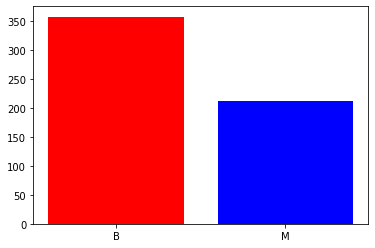

In [187]:
dfPlot = data.groupBy("diagnosis").count()
x = dfPlot.toPandas()['diagnosis']
y = dfPlot.toPandas()['count']
plt.bar(x,y,color=['red', 'blue'])
plt.show()

Null data control is performed for each column in the dataset. These null values ​​reduce the quality of our data. We need to get rid of these values.

In [188]:
# check the number of null values each column contains
from pyspark.sql.functions import isnan, when, count, col

data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----------+
| id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|Unnamed: 32|
+---+---------+-----------+-------

## Data Preparation<a class="anchor" id="data_preparation"></a>

The 'Unnamed: 32' column with all values ​​null is deleted from the dataset. There is no null value in other columns. If there were a small number of null values ​​in other columns, we could fill them with values ​​like column average. We don't need an identity column either

In [0]:
#drop redundant columns
column_names = ['id', 'Unnamed: 32']
data = data.drop(*column_names)
#data.columns

The data in the 'diagnosis' column is of the object type. In order for the program to use this data, it is replaced with numerical data. B = 0, M = 1

In [0]:
# encode the non-numerical column values
from pyspark.sql.functions import when
data = data.withColumn("diagnosis", when(col("diagnosis") == 'B', 0).otherwise(1))
#d.show(5)

Using Heatmap, we can see the correlation of the data features more easily. One of the values with high correlation value is subtracted from the dataset.

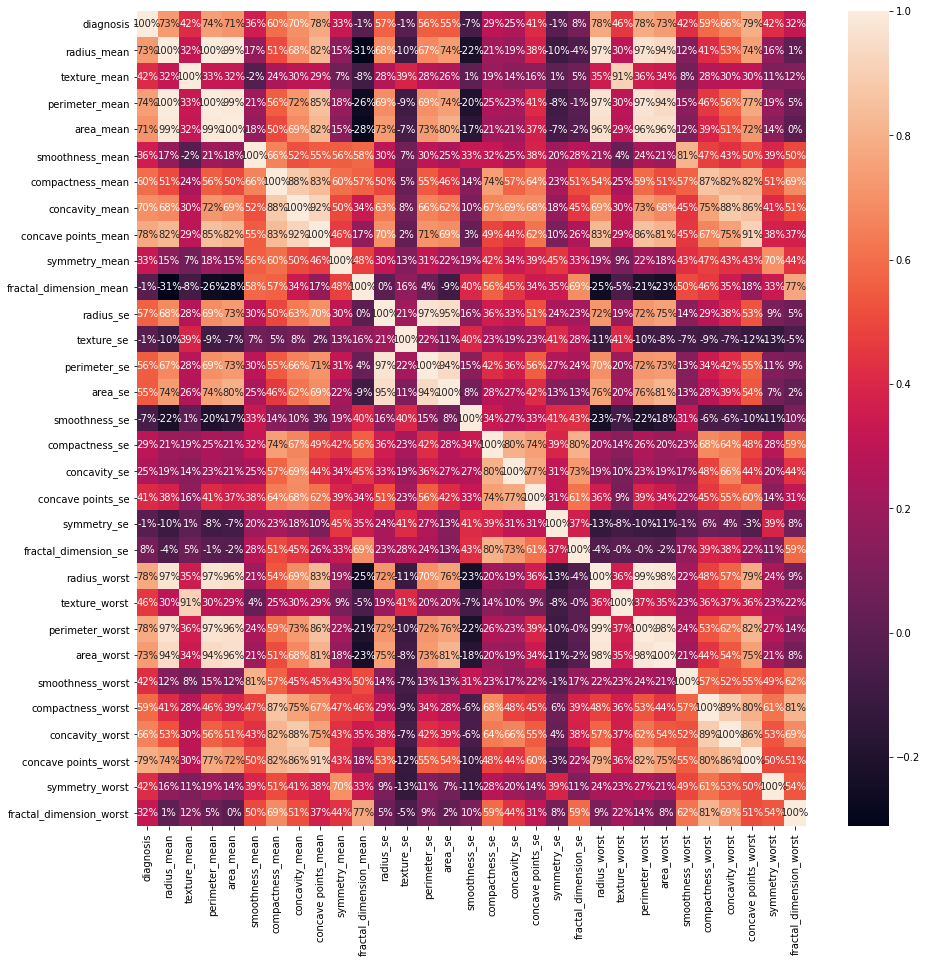

In [191]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=data.columns, outputCol=vector_col)
df_vector = assembler.transform(data).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col, 'pearson')

result = matrix.collect()[0]["pearson({})".format(vector_col)].values
corr_matrix = pd.DataFrame(result.reshape(-1, len(data.columns)), columns=data.columns, index=data.columns)

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, fmt='.0%')

In [0]:
# drop some high correlated columns
column_names = ['radius_mean','perimeter_mean','area_mean','perimeter_worst','area_worst','perimeter_se','area_se','concave points_mean']
OD_nFS = data                       # original data set without feature selection
data = data.drop(*column_names)
OD = data                           # original data set with feature selection

###Normalize the dataframe

In [0]:
# Min-Max Normalize the dataframe
def normalization(data):
    for i in data.columns[1:]:
        max = data.agg({i: "max"}).collect()[0][0]
        min = data.agg({i: "min"}).collect()[0][0]
        max_min = max - min
        data = data.withColumn(i, (col(i)-min) / max_min )
    return data

In [0]:
ND = normalization(data)  # normalize data set with feature selection

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

The 'diagnosis' column is removed from the dataset. Target data are not used in unsupervised learning method. Clustering is done according to the proximity of numerical values. Here the data will be divided into 2 clusters with K-means. Estimates will be made according to these clusters.


In [0]:
def clustering(df):
    vecAssembler = VectorAssembler(inputCols=df.columns[1:], outputCol="features")
    df_kmeans = vecAssembler.transform(df).select('diagnosis', 'features')

    k = 2
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans)
    result = model.transform(df_kmeans).select('diagnosis','features', 'prediction')

    return result

In [0]:
OD_predictions = clustering(OD)
ND_predictions = clustering(ND)
OD_nFS_predictions = clustering(OD_nFS)

## Clustering results<a class="anchor" id="clustering"></a>

Clustering results are printed on the screen. It is evaluated which of our 3 different data sets are more successful.

###Clustring for Original Data

In [197]:
OD_predictions = clustering(OD)
OD_predictions.show(10)
OD_predictions.groupBy("diagnosis","prediction").count().show()

+---------+--------------------+----------+
|diagnosis|            features|prediction|
+---------+--------------------+----------+
|        1|[10.38,0.1184,0.2...|         1|
|        1|[17.77,0.08474,0....|         0|
|        1|[21.25,0.1096,0.1...|         0|
|        1|[20.38,0.1425,0.2...|         1|
|        1|[14.34,0.1003,0.1...|         1|
|        1|[15.7,0.1278,0.17...|         1|
|        1|[19.98,0.09462999...|         0|
|        1|[20.83,0.1189,0.1...|         0|
|        1|[21.82,0.1273,0.1...|         0|
|        1|[24.04,0.1186,0.2...|         0|
+---------+--------------------+----------+
only showing top 10 rows

+---------+----------+-----+
|diagnosis|prediction|count|
+---------+----------+-----+
|        1|         0|  179|
|        1|         1|   33|
|        0|         0|   74|
|        0|         1|  283|
+---------+----------+-----+



(179 + 283) / (176 + 33 + 74 + 283)  =  462/569 = 0,812

Accuracy rate : 81%

###Clustring for Normalized Data

**Normalized dataset gave the best results.**

Thanks to normalization, we were able to get a better result because it regulates the values ​​so that many of our different features can be processed together.

In [198]:
ND_predictions = clustering(ND)
ND_predictions.show(10)
ND_predictions.groupBy("diagnosis","prediction").count().show()

+---------+--------------------+----------+
|diagnosis|            features|prediction|
+---------+--------------------+----------+
|        1|[0.02265809942509...|         1|
|        1|[0.27257355427798...|         0|
|        1|[0.39026039905309...|         1|
|        1|[0.36083868785931...|         1|
|        1|[0.15657761244504...|         1|
|        1|[0.20257017247210...|         1|
|        1|[0.34731146432194...|         1|
|        1|[0.37605681433885...|         1|
|        1|[0.40953669259384...|         1|
|        1|[0.48461278322624...|         1|
+---------+--------------------+----------+
only showing top 10 rows

+---------+----------+-----+
|diagnosis|prediction|count|
+---------+----------+-----+
|        1|         0|   42|
|        1|         1|  170|
|        0|         0|  334|
|        0|         1|   23|
+---------+----------+-----+



(170 + 334) / (42 + 170 + 334 + 23) = 504 / 569 = 0,886

Accuracy rate : 89%

###Clustring for Original Data without Feature Selection 

In [199]:
OD_nFS_predictions = clustering(OD_nFS)
OD_nFS_predictions.show(10)
OD_nFS_predictions.groupBy("diagnosis","prediction").count().show()

+---------+--------------------+----------+
|diagnosis|            features|prediction|
+---------+--------------------+----------+
|        1|[17.99,10.38,122....|         1|
|        1|[20.57,17.77,132....|         1|
|        1|[19.69,21.25,130....|         1|
|        1|[11.42,20.38,77.5...|         0|
|        1|[20.29,14.34,135....|         1|
|        1|[12.45,15.7,82.57...|         0|
|        1|[18.25,19.98,119....|         1|
|        1|[13.71,20.83,90.2...|         0|
|        1|[13.0,21.82,87.5,...|         0|
|        1|[12.46,24.04,83.9...|         0|
+---------+--------------------+----------+
only showing top 10 rows

+---------+----------+-----+
|diagnosis|prediction|count|
+---------+----------+-----+
|        1|         0|   82|
|        1|         1|  130|
|        0|         0|  356|
|        0|         1|    1|
+---------+----------+-----+



(130 + 356) / (82 + 1 + 130 + 356) = 486 / 569 = 0,854

Accuracy rate : 85%

### Visualize the results

In [0]:
def plotGraph(df, df_pred, key ,title):
    df_P = df.toPandas().iloc[:,1:].values
    pred_P = df_pred.toPandas()[key].values

    plt.scatter(df_P[pred_P == 0, 0], df_P[pred_P == 0, 1])
    plt.scatter(df_P[pred_P == 1, 0], df_P[pred_P == 1, 1])
    plt.title(title)

    plt.show()

Clustering results are shown in graphs by reducing the data sets to 2 dimensions.

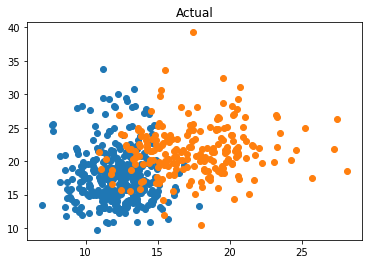

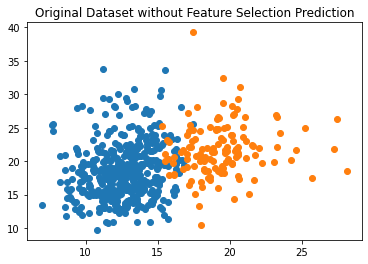

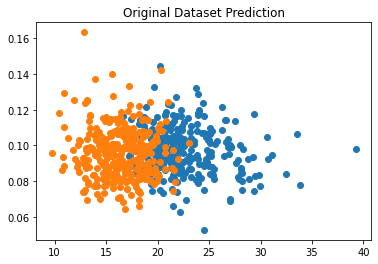

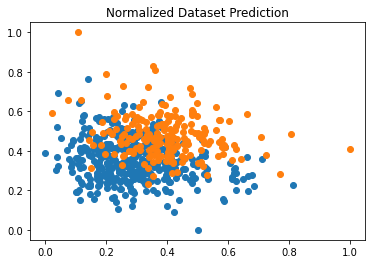

In [201]:
plotGraph(OD_nFS,OD_nFS_predictions.select('diagnosis'),'diagnosis', 'Actual')
plotGraph(OD_nFS,OD_nFS_predictions.select('prediction'),'prediction', 'Original Dataset without Feature Selection Prediction')
plotGraph(OD,OD_predictions.select('prediction'),'prediction', 'Original Dataset Prediction')
plotGraph(ND,ND_predictions.select('prediction'),'prediction', 'Normalized Dataset Prediction')


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

I used Logistic Regression. The logistic model is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. 2 different classifications will be made as people are sick or not.

![alt text](https://miro.medium.com/max/794/1*sz155n98Nvzix0e7Ly-EDQ.jpeg)

In [0]:
# split the data
ND_train_data, ND_test_data = ND.randomSplit([0.7, 0.3], 1)
OD_train_data, OD_test_data = OD.randomSplit([0.7, 0.3], 1)
OD_nFS_train_data, OD_nFS_test_data = OD_nFS.randomSplit([0.7, 0.3], 1)

In [0]:
# normalize train and test data
ND_train_data = normalization(ND_train_data)
ND_test_data = normalization(ND_test_data)

In [0]:
def assambler(data,data2):
    vecAssembler = VectorAssembler(inputCols=data.columns[1:], outputCol="features")
    data = vecAssembler.transform(data).select('diagnosis', 'features')
    vecAssembler = VectorAssembler(inputCols=data2.columns[1:], outputCol="features")
    data2 = vecAssembler.transform(data2).select('diagnosis', 'features')
    return (data,data2)

Data features are converted to vectors for the model training.

In [0]:
ND_train_data, ND_test_data = assambler(ND_train_data,ND_test_data)
OD_train_data, OD_test_data = assambler(OD_train_data,OD_test_data)
OD_nFS_train_data, OD_nFS_test_data = assambler(OD_nFS_train_data,OD_nFS_test_data)

### Train and test the Logistic Regression model with data

In [0]:
from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(labelCol='diagnosis', featuresCol = 'features',  maxIter=10)

def logisticRegression(model, train_data, test_data):
    model = model.fit(train_data)

    predictions = model.transform(test_data)
    return predictions

In [0]:
ND_predictions = logisticRegression(model, ND_train_data, ND_test_data)
OD_predictions = logisticRegression(model, OD_train_data, OD_test_data)
OD_nFS_predictions = logisticRegression(model, OD_nFS_train_data, OD_nFS_test_data)

## Evaluation<a class="anchor" id="evaluation"></a>

In [0]:
# print the classification results for used Model
from sklearn.metrics import classification_report, confusion_matrix

def evaluation(predictions, title):
    y_true = predictions.select(['diagnosis']).collect()
    y_pred = predictions.select(['prediction']).collect()

    print(title)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    predictions.select('diagnosis', 'prediction', 'probability', 'rawPrediction', 'features').show(10,truncate=False)

### Classification result for Original Data

In [209]:
evaluation(OD_predictions, "Evaluation Metrics for Original Data Model")

Evaluation Metrics for Original Data Model
[[103   1]
 [  4  49]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       104
           1       0.98      0.92      0.95        53

    accuracy                           0.97       157
   macro avg       0.97      0.96      0.96       157
weighted avg       0.97      0.97      0.97       157

+---------+----------+------------------------------------------+----------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|diagnosis|prediction|probability                               |rawPrediction                           |features                                                                                                                                                            

### Classification result for Normalized Data

In [210]:
evaluation(ND_predictions, "Evaluation Metrics for Normalized Data Model")

Evaluation Metrics for Normalized Data Model
[[83 21]
 [ 4 49]]
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       104
           1       0.70      0.92      0.80        53

    accuracy                           0.84       157
   macro avg       0.83      0.86      0.83       157
weighted avg       0.87      0.84      0.84       157

+---------+----------+------------------------------------------+------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|diagnosis|prediction|probability                          

### Classification result for Original Data without Feature Selection 

In [211]:
evaluation(OD_nFS_predictions, "Evaluation Metrics for Original Data without Feature Selection Model")

Evaluation Metrics for Original Data without Feature Selection Model
[[102   2]
 [  1  52]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       104
           1       0.96      0.98      0.97        53

    accuracy                           0.98       157
   macro avg       0.98      0.98      0.98       157
weighted avg       0.98      0.98      0.98       157

+---------+----------+------------------------------------------+----------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|diagnosis|prediction|probability                               |rawPrediction                           |features                                                                 

###Cross Validator, Evaluate and Features Weight for Original Dataset 

In [212]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='diagnosis')
evaluator.evaluate(OD_predictions)


0.99111030478955

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(model.regParam, [0.01, 0.5, 2.0])
             .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(model.maxIter, [1, 5, 10])
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations
cvModel = cv.fit(OD_train_data)

In [214]:
# the model's feature weights
weights = cvModel.bestModel.coefficients

for i in tuple(zip(OD.columns[1:],weights)):  print("{}\t\t:{}".format(i[0],i[1]))

texture_mean		:0.02409404423457759
smoothness_mean		:4.888837381678898
compactness_mean		:9.601819410032626
concavity_mean		:12.595123669655658
symmetry_mean		:-10.01532059236621
fractal_dimension_mean		:-236.14735477565588
radius_se		:4.54588120445528
texture_se		:0.2893937015220932
smoothness_se		:13.609661533581258
compactness_se		:-17.80317383860443
concavity_se		:-12.498952398873065
concave points_se		:24.387884874760402
symmetry_se		:-23.32899756058851
fractal_dimension_se		:8.948288222248333
radius_worst		:0.15507058861064296
texture_worst		:0.08287144712303736
smoothness_worst		:9.436387562006342
compactness_worst		:2.385545953395914
concavity_worst		:3.1526385050810473
concave points_worst		:15.601627196986266
symmetry_worst		:8.510337360788776
fractal_dimension_worst		:8.798700508968137


### Feature weight graph

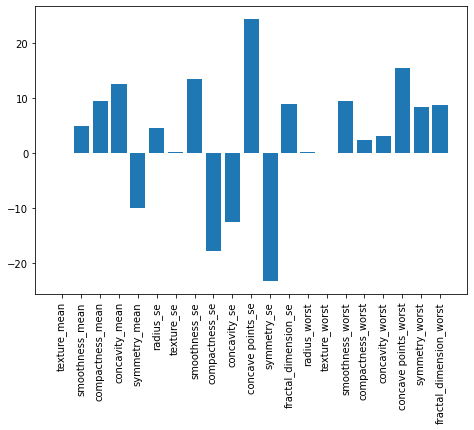

In [218]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.delete(OD.columns[1:],5),np.delete(weights,5))
plt.xticks(rotation=90)
plt.show()

## References<a class="anchor" id="references"></a>

*   https://github.com/aucan/DataScienceTutorials/blob/master/BBM469_Tutorial_8_Machine_Learning_with_Spark.ipynb
*   https://rsandstroem.github.io/sparkkmeans.html
*   https://spark.apache.org/docs/latest/ml-tuning.html
*   https://medium.com/@dhiraj.p.rai/logistic-regression-in-spark-ml-8a95b5f5434c
*   https://runawayhorse001.github.io/LearningApacheSpark/clustering.html
*   http://standarderror.github.io/notes/Plotting-with-PySpark/



List all the sources you used during your work.
This includes jupyter notebooks you found on Internet.
Remeber, your work may not be an original one. However, this document must be genuine. Copy and paste kind of deliveries will be punished badly.


**Disclaimer!** <font color='grey'>This notebook was prepared by <student name(Said Furkan Ayvaz)> as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>